In [4]:
import os
from os.path import exists
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt
from matplotlib import animation
import math

from keras import backend as K

# ___library_import_statements___
import pandas as pd

import time
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
import MetaTrader5 as mt5

Num GPUs Available:  1


In [74]:
# -------------------------------------------
# Constan
# -------------------------------------------
# NumF = 1*24*60*60//24
# NumP = 24*60*60//24//10
# size_Reduce = (30*3)
minni_add = 5
mt5Range_time = mt5.TIMEFRAME_M5
maxCntCore = 100*5*60//minni_add
NumDataPerTest = 30*5*60//minni_add
NumF = 5*15//minni_add
NumP = 5*5//minni_add
size_Reduce = 1
min_delta_cmp = 0.0010
# EURUSDm | USOILm | BTCUSDm
nameFile = "data_EURUSDm"
type_tick = "EURUSDm"

In [75]:
numInput = 12

# -------------------------------------------
# Model configuration
# -------------------------------------------
additional_metrics = [] #['binary_accuracy']
batch_size = 60
input_dims = numInput
output_dims = NumF
loss_function = "mean_squared_error" #"mean_squared_error" "binary_crossentropy" "mae"
number_of_epochs = 150
optimizer = Adam()
validation_split = 0.000
verbosity_mode = 0

In [77]:
# -------------------------------------------
# Function
# -------------------------------------------
def hour_rounder(t):
    return t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
    
def demathPre(xValue, plus=False):
  global max_value, min_value, scaler
  xValue = scaler.inverse_transform(xValue.reshape((-1, 1)))
  xValue = np.float64(xValue)
  """
  if plus:
    xValue = xValue ** (1 / 4.0)
    xValue/=pow(10, 8)
    #xValue*=max_value
    xValue+=min_value
  #xValue = np.vectorize(lambda x: int(x >= 0.5))(xValue)
  return np.round(xValue, 6)
  """
  return np.round(xValue, 5)
  #return np.round(xValue, 4)
def enmathPre(xValue):
  global max_value, min_value, scaler, numInput
  """
  xValue-=min_value
  #xValue/=max_value
  xValue*=pow(10, 8)
  xValue**=4
  """
  xValue_0_3 = np.copy(xValue[0:, 0:4])
  xValue_0_3 = scaler.fit_transform(xValue_0_3.reshape((-1, 1)))
  xValue_0_3 = xValue_0_3.reshape((-1, 4))
  xValue[0:, 0:4] = xValue_0_3

  xValue_4 = np.copy(xValue[0:, 4])
  scaler_volume = StandardScaler()
  xValue_4 = scaler_volume.fit_transform(xValue_4.reshape((-1, 1)))
  xValue_4 = xValue_4.reshape((-1, 1))
  xValue[0:, 4] = xValue_4.ravel()
  
  xValue_5 = np.copy(xValue[0:, 5])
  scaler_MACD = StandardScaler()
  xValue_5 = scaler_MACD.fit_transform(xValue_5.reshape((-1, 1)))
  xValue_5 = xValue_5.reshape((-1, 1))
  xValue[0:, 5] = xValue_5.ravel()
  
  xValue_6_9 = np.copy(xValue[0:, 6:10])
  xValue_6_9 = (xValue_6_9-50)/50 *2
  xValue[0:, 6:10] = xValue_6_9
  
  xValue_10 = np.copy(xValue[0:, 10])
  scaler_ATR = StandardScaler()
  xValue_10 = scaler_ATR.fit_transform(xValue_10.reshape((-1, 1)))
  xValue_10 = xValue_10.reshape((-1, 1))
  xValue[0:, 10] = xValue_10.ravel()

  xValue_11 = np.copy(xValue[0:, 11])
  scaler_OBV = StandardScaler()
  xValue_11 = scaler_OBV.fit_transform(xValue_11.reshape((-1, 1)))
  xValue_11 = xValue_11.reshape((-1, 1))
  xValue[0:, 11] = xValue_11.ravel()
  
  return xValue
def formatDataset(data, dataForY, scaler_x, num_in, num_out):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x - (NumF//size_Reduce - 1)
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  y = np.zeros((numData, num_out), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
    y[i] = np.copy(data[i+scaler_x: i+scaler_x+num_out, 3])
    #y[i] = data[i+scaler_x+j+(NumF//size_Reduce - 1)][3]
    # y[i] = (dataForY[i+scaler_x+j+5] >= dataForY[i+scaler_x+j+11])
  return (x, y)
def formatDataPredist(data, scaler_x, num_in):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
  return x
def predictCon(input_dims, scale_x, scale_y, data):
  global model, np, random
  test_x = np.zeros((scale_x, input_dims))
  for i in range(0, scale_x):
    test_x[i] = data[i]
  test_y = np.zeros((len(data) - scale_x,  scale_y))
  for i in range(0, len(data) - scale_x):
    test_y[i] = model.predict(test_x.reshape((1, scale_x, input_dims))).T[0][0]
    shift(test_x, -scale_y, cval=np.zeros((input_dims)))
    for j in range(scale_x-scale_y, scale_x):
      test_x[j] = test_y[i][j - scale_x + scale_y] + (random.random()*2*0.03 - 0.035)
  return test_y
def extract_seqX_outcomeY(data, scale_x, input_dims):
  test_x = np.zeros((len(data) - scale_x, scale_x, input_dims), dtype = np.float64)
  for i in range(0, len(data) - scale_x):
    test_x_child = data[i:i+scale_x]
    test_x[i] = test_x_child;
  return test_x
def DrawPlot(data, up_x, label, date = [], step = 1, noinv = False):
  global demathPre
  tranfor = demathPre
  if tranfor and (not noinv):
    data = tranfor(data)
  if len(date) == 0:
    date = np.zeros(data.shape)
    for i in range(0, len(data), step):
      date[i] = i + up_x
  # print(data.shape, date.shape)
  plt.plot(date, data, label = label)
def reduceSizeArr(data, child_size):
  num_child = len(data)//child_size
  child_arr = np.zeros((num_child, numInput), dtype = np.float64);
  for i in range(0, num_child):
    child_value = 0.0;
    for j in range(0, child_size):
      child_value = child_value + data[i*child_size + j]/child_size
    child_arr[i] = child_value;
  return child_arr
def calPrize(val_l, val_r, mode):
  re_val = (val_l[3] - val_r[3])*mode
  return re_val;
def find_best_pos(data):
  minest = data.argmin()
  maxest = data.argmax()
  return (min(minest, maxest), max(minest, maxest))
  
# -------------------------------------------
# Function stoke
# -------------------------------------------
_DP = {
    "Open": 0,
    "High": 1,
    "Low": 2,
    "Close": 3,
    "Volume": 4,
    "MACD": 5,
    "MACDsig": 5,
    "RSI": 6,
    "SOk": 7,
    "SOd": 8,
    "ADX": 9,
    "ATR": 10,
    "OBV": 11,
}
def cal_MACD(df, n_fast, n_slow, n_smooth):
  df = pd.DataFrame(df)
  data = df[_DP['Close']]
  fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
  slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
  MACD = pd.Series(fastEMA-slowEMA, name = _DP['MACD'])
  MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name=_DP['MACDsig'])
  df[_DP['MACDsig']] = MACDsig
  return df
def cal_RSI(df, n):
    df = pd.DataFrame(df)
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, _DP['High']] - df.loc[i, _DP['High']]
        DoMove = df.loc[i, _DP['Low']] - df.loc[i + 1, _DP['Low']]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI) * 100, name='RSI_' + str(n))
    df[_DP['RSI']] = RSI
    return df
def cal_stoch_k(df, k):
    df = pd.DataFrame(df)
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """

    SOk = pd.Series((df[_DP['Close']] - df[_DP['Low']].rolling( window = k ).min()) / (df[_DP['High']].rolling( window = k ).max() - df[_DP['Low']].rolling( window = k ).min()) *100, name='SO%k')
    df[_DP['SOk']] = SOk
    return df
def cal_stoch_d(df, k, n):
    df = pd.DataFrame(df)
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df[_DP['Close']] - df[_DP['Low']].rolling( window = k ).min()) / (df[_DP['High']].rolling( window = k ).max() - df[_DP['Low']].rolling( window = k ).min()) *100, name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df[_DP['SOd']] = SOd
    return df
def cal_ADX(df, n, n_ADX):
    df = pd.DataFrame(df)
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, _DP['High']] - df.loc[i, _DP['High']]
        DoMove = df.loc[i, _DP['Low']] - df.loc[i + 1, _DP['Low']]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, _DP['High']], df.loc[i, _DP['Close']]) - min(df.loc[i + 1, _DP['Low']], df.loc[i, _DP['Close']])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI) *100).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df[_DP['ADX']] = ADX
    return df
def cal_ATR(df, n):
    df = pd.DataFrame(df)
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, _DP['High']], df.loc[i, _DP['Close']]) - min(df.loc[i + 1, _DP['Low']], df.loc[i, _DP['Close']])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df[_DP['ATR']] = ATR
    return df
def cal_OBV(df, n):
    df = pd.DataFrame(df)
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, _DP['Close']] - df.loc[i, _DP['Close']] > 0:
            OBV.append(df.loc[i + 1, _DP['Volume']])
        if df.loc[i + 1, _DP['Close']] - df.loc[i, _DP['Close']] == 0:
            OBV.append(0)
        if df.loc[i + 1, _DP['Close']] - df.loc[i, _DP['Close']] < 0:
            OBV.append(-df.loc[i + 1, _DP['Volume']])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df[_DP['OBV']] = OBV_ma
    return df


def PreProcessData(data):
  global numInput
  res = np.zeros((numInput), dtype = np.float64);
  res[0] = data['open']
  res[1] = data['high']
  res[2] = data['low']
  res[3] = data['close']
  res[4] = data['tick_volume']
  return res

In [78]:
# -------------------------------------------
# Connect to MetaTrader 5
# -------------------------------------------
if not mt5.initialize(login=89715371, password="8zVtw5FGfc4bvus", server='Exness-MT5Real6'):
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
  
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=3337, maxbars=100000, codepage=0, ping_last=36427, community_balance=0.0, retransmission=0.0, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 3337, '30 Jun 2022')


In [79]:
# -------------------------------------------
# Get data realtime
# -------------------------------------------
cntCore = []

file_exists = exists(nameFile)
file_exists = False
if file_exists == False:
  timezone = datetime.timezone.utc
  utc_from = datetime.datetime.now(timezone)
  Data_ticks = mt5.copy_rates_from(type_tick, mt5Range_time, utc_from, maxCntCore)
  mt5.shutdown()
  # BTCUSDm
  SStock = datetime.datetime.utcfromtimestamp(Data_ticks[len(Data_ticks)-1]['time'].item()) + datetime.timedelta(hours=7)
  data = np.zeros((len(Data_ticks), numInput), dtype = np.float64)
  for i in range(0, len(data)):
    data[i] = PreProcessData(Data_ticks[i])
  SaveData = np.copy(data)
  with open(nameFile, 'wb') as f:
    np.save(f, SaveData)
else:
  with open(nameFile, 'rb') as f:
    SaveData = np.load(f)    

In [40]:
print(SaveData.shape);

(6000, 12)


In [80]:
# Cal atribu
SaveData = cal_MACD(SaveData, 12, 26, 9).to_numpy(dtype=np.float64)
SaveData = cal_RSI(SaveData, 14).to_numpy(dtype=np.float64)
SaveData = cal_stoch_k(SaveData, 14).to_numpy(dtype=np.float64)
SaveData = cal_stoch_d(SaveData, 14, 3).to_numpy(dtype=np.float64)
SaveData = cal_ADX(SaveData, 14, 14).to_numpy(dtype=np.float64)
SaveData = cal_ATR(SaveData, 14).to_numpy(dtype=np.float64)
SaveData = cal_OBV(SaveData, 14).to_numpy(dtype=np.float64)

 30


(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
0 4
Predist:  1.00251  /  1.00199
Result:  No BUY!
CMP l:  1.00755
CMP r:  1.00783
1/1 [==============================] - 0s 34ms/step


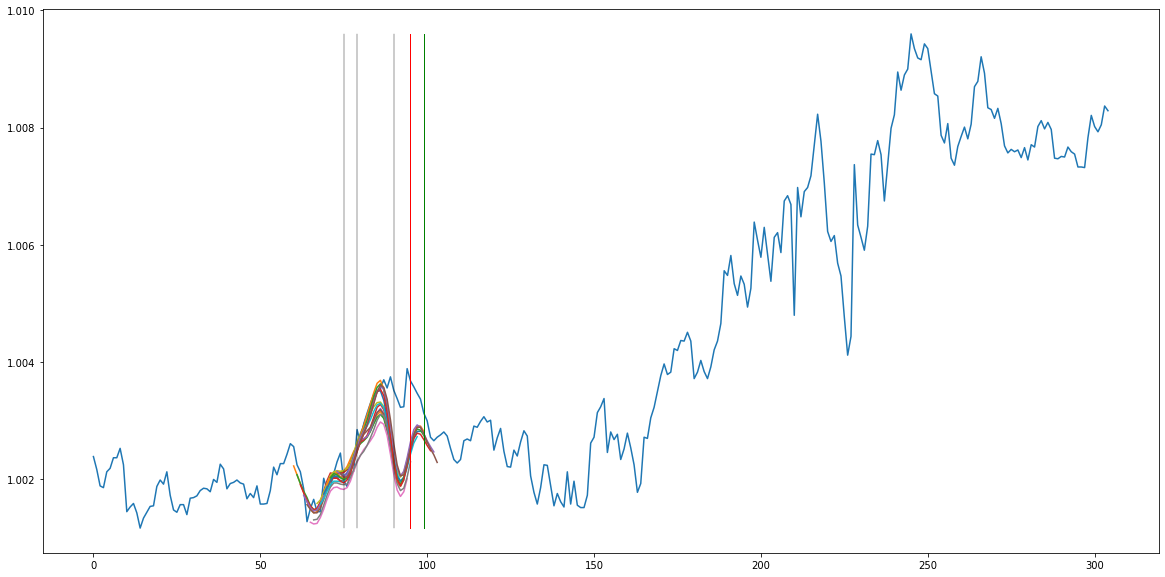

Bonus:  0
Acc money 10000
Loop:  1  /  30  | win(  0  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
0 9
Predist:  1.018  /  1.01615
Result:  Sell
CMP l:  1.01594
CMP r:  1.01478
1/1 [==============================] - 0s 35ms/step


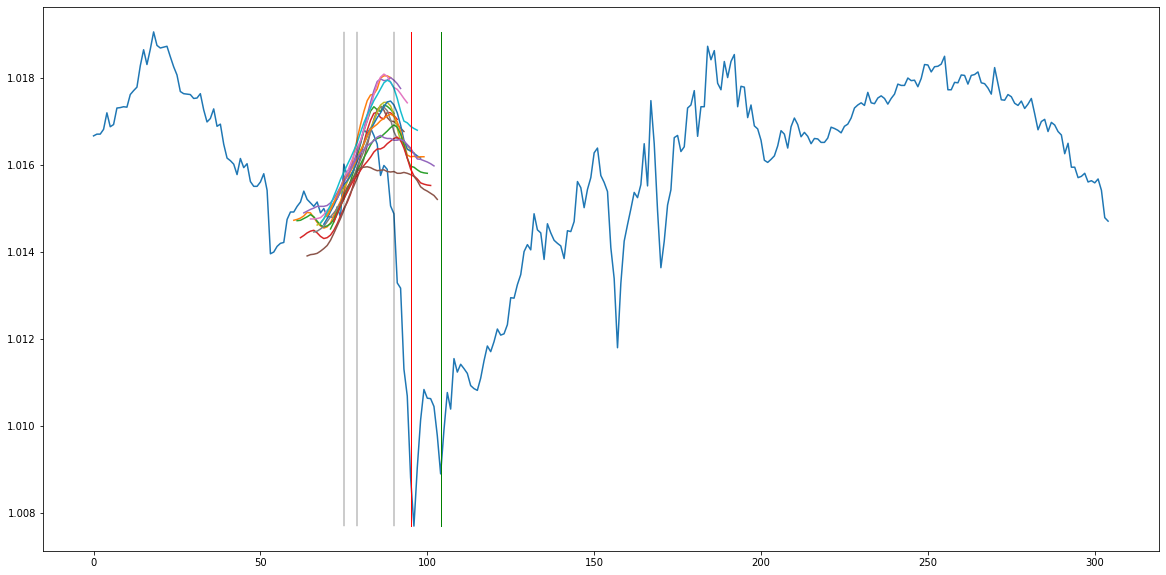

Bonus:  0.0011600000000000499
Acc money 10000.00116
Loop:  2  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
3 9
Predist:  1.01217  /  1.01256
Result:  No BUY!
CMP l:  1.01375
CMP r:  1.01452
1/1 [==============================] - 0s 57ms/step


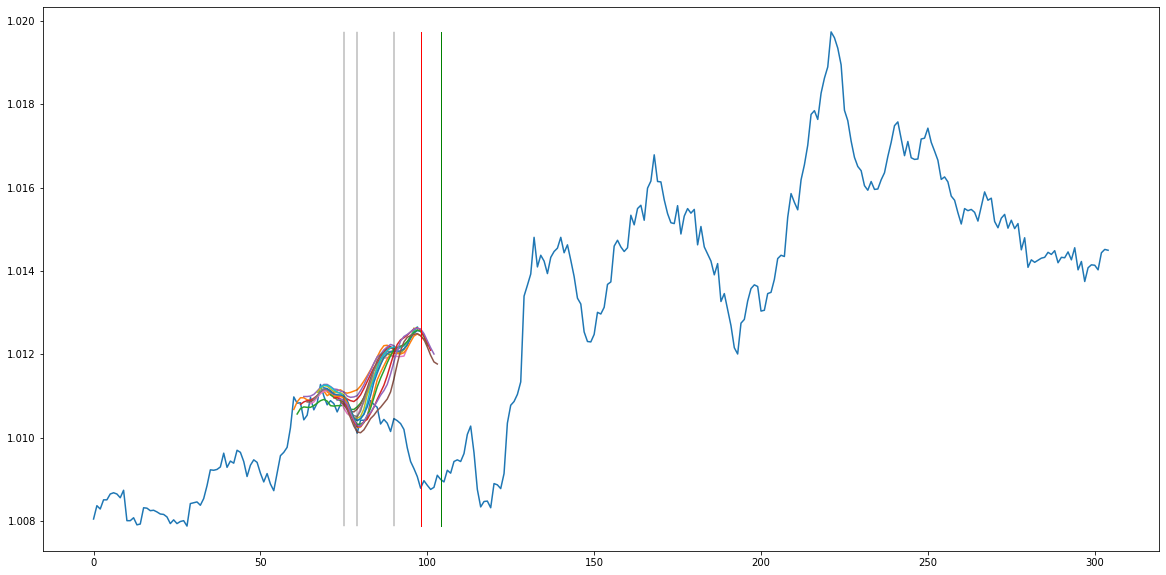

Bonus:  0
Acc money 10000.00116
Loop:  3  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
8 9
Predist:  1.01768  /  1.01737
Result:  No BUY!
CMP l:  1.01704
CMP r:  1.01725
1/1 [==============================] - 0s 41ms/step


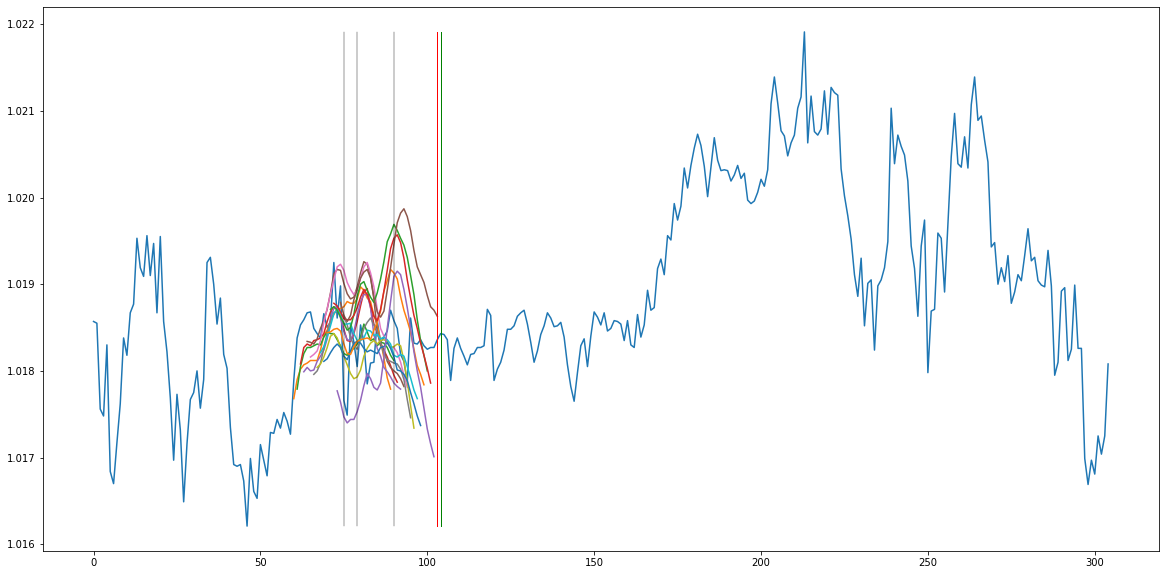

Bonus:  0
Acc money 10000.00116
Loop:  4  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
2 8
Predist:  1.01686  /  1.01738
Result:  No BUY!
CMP l:  1.00712
CMP r:  1.00857
1/1 [==============================] - 0s 53ms/step


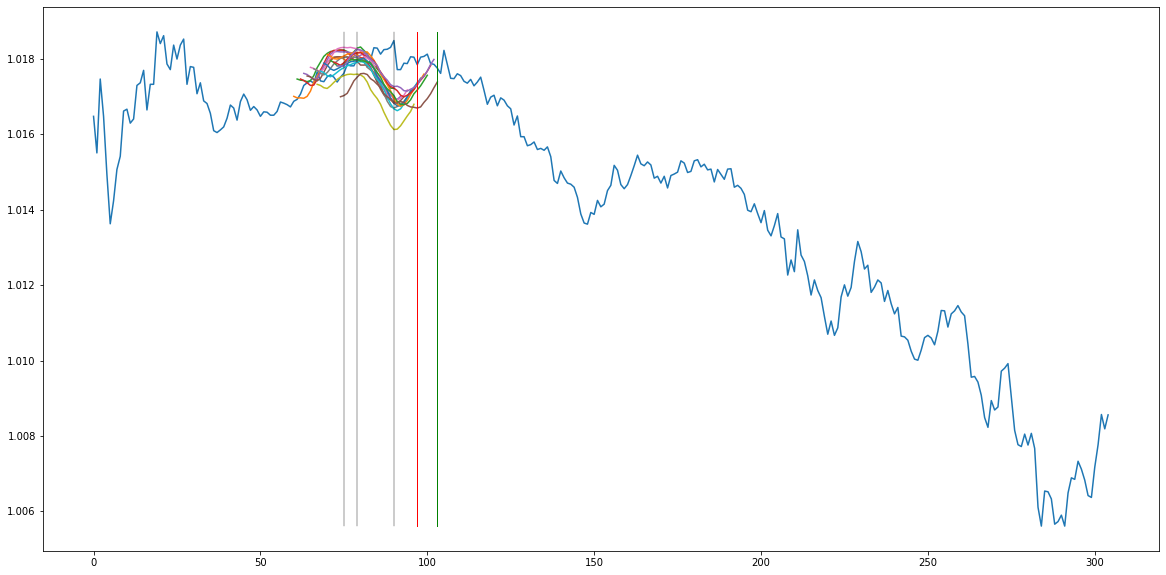

Bonus:  0
Acc money 10000.00116
Loop:  5  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 4s 4s/step
(1, 15)
2 6
Predist:  1.00322  /  1.00304
Result:  No BUY!
CMP l:  1.00627
CMP r:  1.00608
1/1 [==============================] - 0s 117ms/step


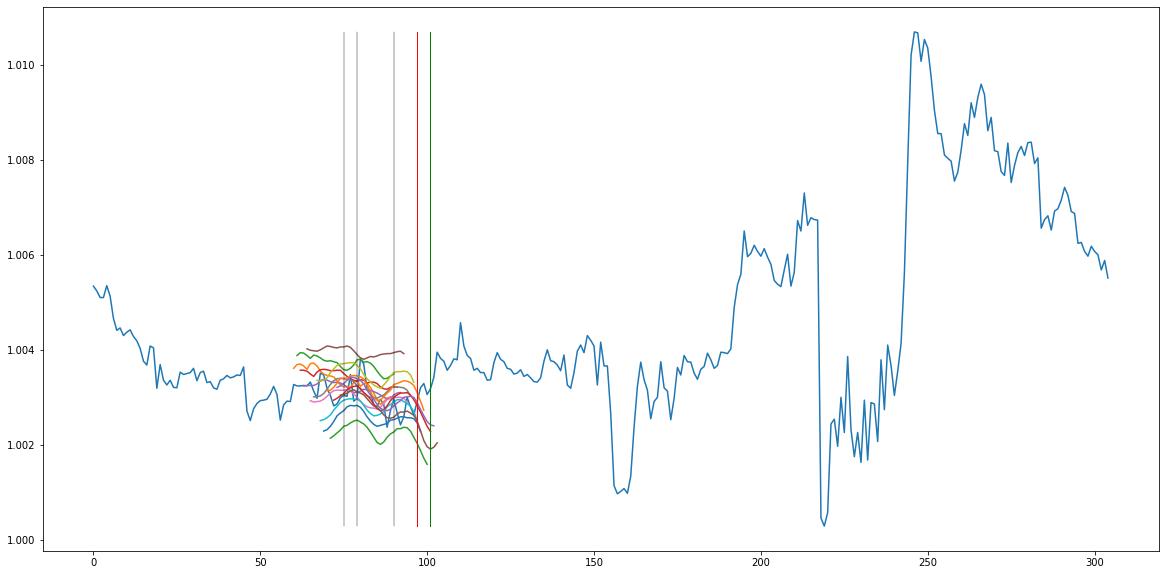

Bonus:  0
Acc money 10000.00116
Loop:  6  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 2s 2s/step
(1, 15)
4 9
Predist:  1.01306  /  1.01255
Result:  No BUY!
CMP l:  1.0129
CMP r:  1.01352
1/1 [==============================] - 0s 39ms/step


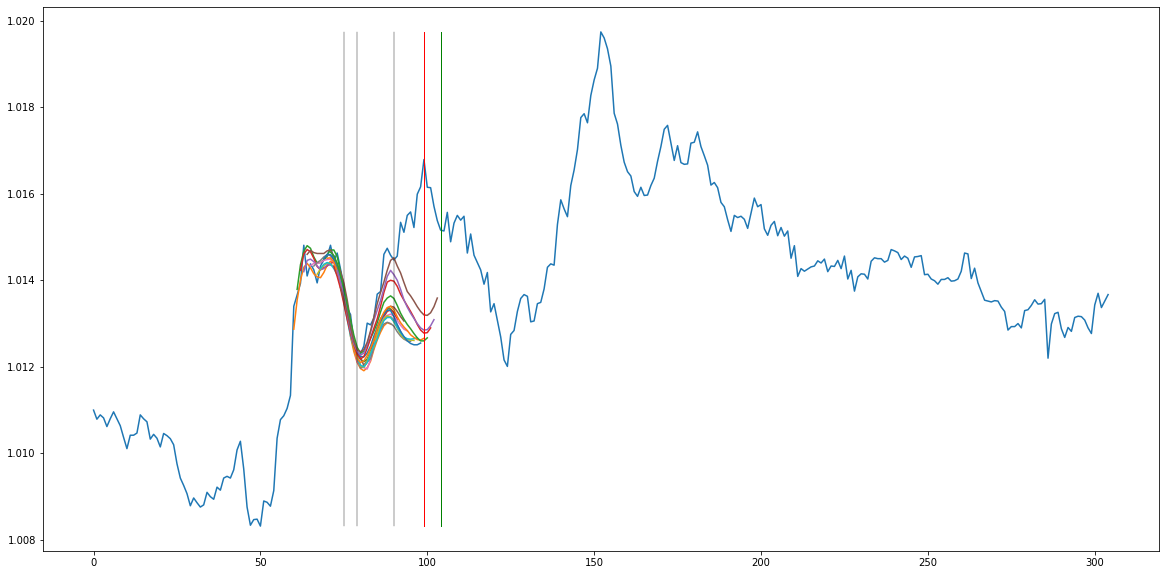

Bonus:  0
Acc money 10000.00116
Loop:  7  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)
(1, 60, 12)
1/1 [==============================] - 3s 3s/step
(1, 15)
2 9
Predist:  1.05278  /  1.0531
Result:  No BUY!
CMP l:  1.04407
CMP r:  1.04429
1/1 [==============================] - 0s 82ms/step


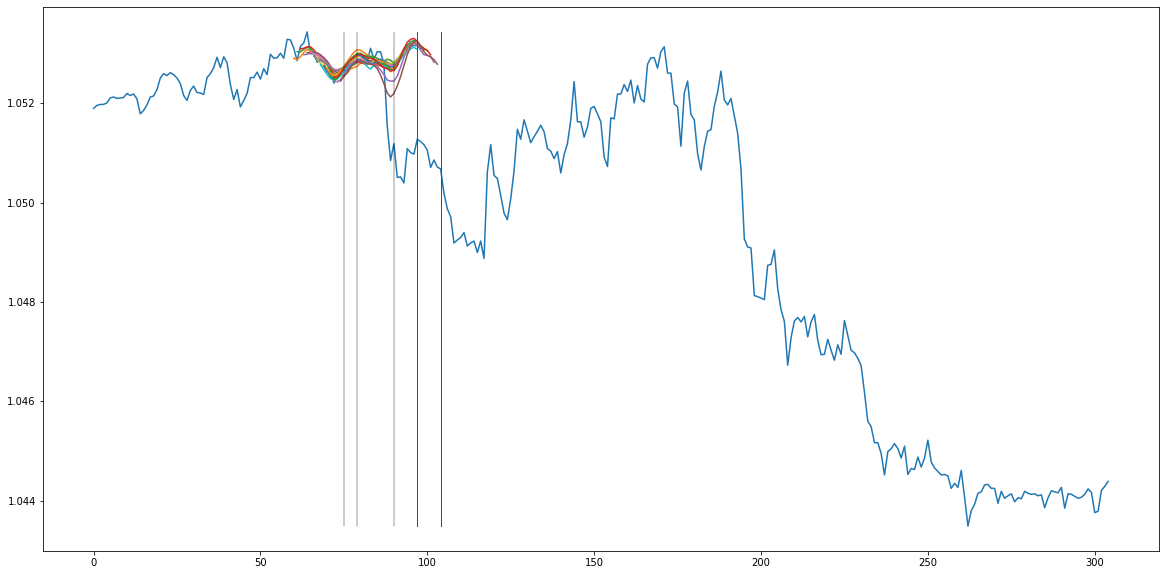

Bonus:  0
Acc money 10000.00116
Loop:  8  /  30  | win(  1  ) / loss(  0  )
(6000, 12) (2015, 12)
(1800, 12)
(1726, 60, 12) (1726, 15)


In [ ]:
scaler = StandardScaler()
# -------------------------------------------
# Function AI
# -------------------------------------------
def runAI(noChangeData):
  global numInput, NumF, NumP, size_Reduce, NumDataPerTest, SStock, MStock, EStock
  global additional_metrics, batch_size, input_dims, output_dims, loss_function, number_of_epochs, optimizer, validation_split, verbosity_mode
  # -------------------------------------------
  # Format size data
  # -------------------------------------------
  sub_log = 200
  cap_range_up = batch_size + 30
  cap_range_up_sub = NumF + batch_size + 30 + sub_log
  lenData = NumDataPerTest*size_Reduce+(NumF) + sub_log
  ranPos = np.random.randint(lenData, len(noChangeData) + 1)
  orgData = np.copy(noChangeData[len(noChangeData)-ranPos:len(noChangeData)-ranPos+lenData])
  # test_orgData = np.copy(orgData) * 10000
  test_orgData = np.copy(orgData)
  orgData = reduceSizeArr(orgData, size_Reduce)
  print(noChangeData.shape, orgData.shape)

  orgData = enmathPre(orgData)

  data = np.copy(orgData[:len(orgData) - (NumF//size_Reduce) - sub_log])
  dataForY = np.copy(test_orgData[:len(test_orgData) - (NumF//size_Reduce) - sub_log])
  print(data.shape)

  # -------------------------------------------
  # Format data
  # -------------------------------------------
  (x_train, y_train) = formatDataset(data, dataForY, batch_size, input_dims, output_dims)
  print(x_train.shape, y_train.shape)

  # -------------------------------------------
  # Building model
  # -------------------------------------------
  K.clear_session()
  # Define the Keras model
  model = Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(batch_size, input_dims)))
  model.add(Dense(batch_size*input_dims, activation=tf.keras.activations.linear))
  model.add(Dense(input_dims, activation=tf.keras.activations.linear))
  model.add(LSTM(batch_size, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(batch_size, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(batch_size, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(12*batch_size, activation=tf.keras.activations.linear))
  model.add(Dense(batch_size, activation=tf.keras.activations.linear))
  model.add(Dense(output_dims, activation=tf.keras.activations.linear))
  # model.add(Dense(output_dims, activation=tf.keras.activations.sigmoid))
  # Compile the model
  model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
  # Give a summary
  #model.summary()
  
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode="min", min_delta=0.001, restore_best_weights=True) #,min_delta=0.00001)
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=80,min_delta=0.001, mode="min", restore_best_weights=True,)
  history = model.fit(x_train, y_train, validation_split=validation_split, batch_size=54, epochs=number_of_epochs, verbose=verbosity_mode, callbacks=[], shuffle=True) #, shuffle=True, callbacks=[early_stopping])
  #model.save_weights("/my_model.h", overwrite=True, save_format=None, options=None)

  pos_predist_data = len(data)-1*batch_size-1
  test_last_x_All = np.copy(data[pos_predist_data:])
  test_last_x_All = formatDataPredist(test_last_x_All, batch_size, input_dims)
  print(test_last_x_All.shape)
  test_last_y_All = model.predict(test_last_x_All)
  test_last_y_All = demathPre(test_last_y_All, plus=True).T
  print(test_last_y_All.shape)

  (pos_l, pos_r) = find_best_pos(test_last_y_All[0][NumP:]);
  print(pos_l, pos_r)
  BackPrize = test_last_y_All[0][pos_l]
  test_last_y = test_last_y_All[0][pos_r]

  #BackPrize = test_orgData[len(test_orgData)-7] / 10000
  print("Predist: ", BackPrize, " / ", test_last_y)
  test_sellorbuy = (BackPrize - test_last_y >= min_delta_cmp)
  test_NoBuyNoSell = (abs(BackPrize - test_last_y) <= min_delta_cmp)
  print("Result: ", ("No BUY!" if test_NoBuyNoSell else ("Sell" if test_sellorbuy else "Buy"))) 
  
  orgData_close = np.zeros((len(orgData)), dtype = np.float64);
  for i in range(0, len(orgData)):
    orgData_close[i] = orgData[i][3]
  
  #len_range = (NumF - NumP + 1)
  len_range = (NumF - NumP + 1)//size_Reduce
  print("CMP l: ", test_orgData[len(test_orgData) - len_range + pos_l][3])
  print("CMP r: ", test_orgData[len(test_orgData) - len_range + pos_r][3])

  CopyData = np.copy(data)
  fig = plt.figure(figsize = (20,10))
  CopyData = CopyData[len(CopyData) - cap_range_up:]
  test_x = extract_seqX_outcomeY(CopyData, np.copy(batch_size), input_dims)
  test_y = model.predict(test_x).T
  orgData_close = orgData_close[len(orgData_close) - cap_range_up_sub:]
  DrawPlot(orgData_close, 0, 'Train 0', date = [], step = 1)

  for i in range(0, output_dims):
    DrawPlot(test_y[i], batch_size + i, 'P' + str(i), date = [], step = 1)
  # for i in range(0, output_dims):
  #   DrawPlot(test_y[len(test_y) - i - 1], len(data)-i, 'P' + str(i), date = [], step = 1)
  
  valSpitPos = len(CopyData)
  minline = np.min(demathPre(orgData_close))
  maxline = np.max(demathPre(orgData_close))
  
  plt.plot([valSpitPos + NumP + pos_l, valSpitPos + NumP + pos_l], [minline, maxline], 'r-', lw=1)
  plt.plot([valSpitPos + NumP + pos_r, valSpitPos + NumP + pos_r], [minline, maxline], 'g-', lw=1)

  plt.plot([valSpitPos-(NumF//size_Reduce), valSpitPos-(NumF//size_Reduce)], [minline, maxline], 'k-', lw=0.4)
  plt.plot([valSpitPos, valSpitPos], [minline, maxline], 'k-', lw=0.4)
  plt.plot([valSpitPos-len_range, valSpitPos-len_range], [minline, maxline], 'k-', lw=0.4)
    
  """
  fig = plt.figure(figsize = (20,10))
  DrawPlot(orgData, 0, 'Train 0', date = [])
  test_x = extract_seqX_outcomeY(orgData, batch_size, input_dims)
  test_y = model.predict(test_x)
  for i in range(0, 1):
      DrawPlot(test_y.T[i], batch_size + 11 + i, 'Predicted Closing Price (' + str(i) + ')', date = [])
  plt.show()
  """
  plt.show()
  
  # -------------------------------------------
  # Print output
  # -------------------------------------------
  #pos_evel = int(len(x_train)*(1.0-validation_split))
  #scores = model.evaluate(x_train[:pos_evel], y_train[:pos_evel], verbose=0)
  #print("Accuracy see: %.2f%%" % (scores[1]*100), y_train[:pos_evel].shape)
  if test_NoBuyNoSell:
    return 0
  elif test_sellorbuy == 1:
    return calPrize(test_orgData[len(test_orgData) - len_range + pos_l], test_orgData[len(test_orgData) - len_range + pos_r], 1)
  elif test_sellorbuy == 0:
    return calPrize(test_orgData[len(test_orgData) - len_range + pos_l], test_orgData[len(test_orgData) - len_range + pos_r], -1)
  
  return 0
    
Money = 10000
numItems = 1
arrMoney = []
numLoop = int(input())
winG = 0
lossG = 0
for i in range(0, numLoop):
  newSaveData = np.copy(SaveData)
  status = runAI(newSaveData)
  if status > 0:
    winG = winG + 1
  if status < 0:
    lossG = lossG + 1
  print("Bonus: ", status*numItems)
  Money = Money + status*numItems
  print("Acc money", Money)
  arrMoney.append(Money)
  print("Loop: ", (i+1), " / ", numLoop, " | win( ", winG, " ) / loss( ", lossG, " )")
  #time.sleep(0.6)

fig = plt.figure(figsize = (20,10))
arrMoney = np.array(arrMoney)
DrawPlot(arrMoney, 0, 'Acc money', date = [], noinv=True)
plt.show()